In [1]:
from braket.tracking import Tracker
t = Tracker().start()

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
h =  np.array([0.002604436005845128, 0.0001475925102276803, 0.00027610744514037285, 0.0009531352190088845, 0.0008832730418414711, 0.0005514854135555177, 0.00036824724562903213, 0.0007795499217198617, 0.0010928987465737147, 0.0005110770116494802])
J= np.array([[0.00032046046738773236, 2.9170726800890566e-05, 4.794455109070797e-05, 1.743194222284266e-05, 4.396621124520363e-05, 5.580537021872531e-05, 4.819681199885957e-05, 2.360712380745998e-05, 4.9583783787242055e-05, 2.4848893910628197e-05],
[2.9170726800890566e-05, 5.518250394454241e-05, 3.8806268993469535e-05, 1.7251409891672705e-05, 2.6771444211360497e-05, 2.3527246116971536e-05, 1.8676009091018325e-05, 1.8035176537351594e-05, 3.0913523658249386e-05, 1.632152003270879e-05],
[4.794455109070797e-05, 3.8806268993469535e-05, 8.180208036570616e-05, 1.828037765705621e-05, 2.4329766900505015e-05, 3.109377385312019e-05, 2.7568321236511164e-05, 1.9348697120987928e-05, 3.5751538282575865e-05, 2.004294471810628e-05],
[1.743194222284266e-05, 1.7251409891672705e-05, 1.828037765705621e-05, 4.793731174059693e-05, 1.2446104022834137e-05, 1.9071729679101816e-05, 1.7672868206903787e-05, 3.509184475515416e-05, 2.0135676427363255e-05, 3.307663785139458e-05],
[4.396621124520363e-05, 2.6771444211360497e-05, 2.4329766900505015e-05, 1.2446104022834137e-05, 9.123253763409188e-05, 2.6427424441009536e-05, 1.7149641051083732e-05, 1.0915167979545485e-05, 2.5661130513084227e-05, 1.2722563077307526e-05],
[5.580537021872531e-05, 2.3527246116971536e-05, 3.109377385312019e-05, 1.9071729679101816e-05, 2.6427424441009536e-05, 5.385214180747792e-05, 3.4948035197358135e-05, 2.0968991233564606e-05, 3.772708295933949e-05, 2.0513966060119692e-05],
[4.819681199885957e-05, 1.8676009091018325e-05, 2.7568321236511164e-05, 1.7672868206903787e-05, 1.7149641051083732e-05, 3.4948035197358135e-05, 5.5854269912009204e-05, 1.802057800501208e-05, 3.632726388287251e-05, 1.8630759753540577e-05],
[2.360712380745998e-05, 1.8035176537351594e-05, 1.9348697120987928e-05, 3.509184475515416e-05, 1.0915167979545485e-05, 2.0968991233564606e-05, 1.802057800501208e-05, 4.3121136886459995e-05, 2.1803859656732146e-05, 3.3751971619564626e-05],
[4.9583783787242055e-05, 3.0913523658249386e-05, 3.5751538282575865e-05, 2.0135676427363255e-05, 2.5661130513084227e-05, 3.772708295933949e-05, 3.632726388287251e-05, 2.1803859656732146e-05, 8.224767523212344e-05, 2.3415689187458213e-05],
[2.4848893910628197e-05, 1.632152003270879e-05, 2.004294471810628e-05, 3.307663785139458e-05, 1.2722563077307526e-05, 2.0513966060119692e-05, 1.8630759753540577e-05, 3.3751971619564626e-05, 2.3415689187458213e-05, 4.497062771499336e-05]])

In [4]:
H = None
for i in range(J.shape[0]):
  if H is None:
    H = -h[i] * (qml.PauliZ(i) @ qml.Identity(i))
  else:
    H -= h[i] * (qml.PauliZ(i) @ qml.Identity(i))

for i in range(J.shape[0]):
  for j in range(J.shape[1]):
    if H is None:
      H = J[i][j] * (qml.PauliZ(i) @ qml.PauliZ(j)) # i = 0, j = 0
    else:
      if i != j:
        H += J[i][j] * (qml.PauliZ(i) @ qml.PauliZ(j))
      elif i == j:
        H += J[i][j] * (qml.Identity(i))

# VQE research
Taking into account the specificity of the QUBO (mainly in the sence of Portfolio Optimization) problem and its solution method, specifically, VQE method, the most descent technique to mitigate errors is to modify ansatz.

First of all, we need to talk about general problems, related to constructing an ansatz.
1. The more expressible anzats is, the higher chance that it might be stuck in the Burren Plateau.

Considering the QUBO problem (at least in my personal opinion), the loss function or Hamiltonian does not suffer from this issue, due to the mathematical formulation of the problem (the ground state most certainly exists and it is discriminable from other energy states, which means that global minima can be found efficiently).

2. Solution of the QUBO problem is classical computational state (or one of the set of computational states with almost equivalent energies).

That means, in contrast, for example, for finding ground state energies in quantum chemistry problems, that solution is not a superposition of some basis vectors with (maybe) complex coefficients -- histogram, taken after exectuing a noticable number of shots, should look like a ~90% into the true lowest energy state of the Hamiltonian, which can be most certainly approximated to be the solution.

# Quantum Error Mitigation
Considering facts, stated above, one can come up with an idea to check how different realizations of ansatzes affect the evolution of Hamiltonian expected value under the gradient descent to ground state.

The most naive, simple and mature idea is to just make one layer of controllable rotations around y-axis (RY), because, as have been said, there are no complex coefficients due to specifity of QUBO. Let's check how simulators will handle this problem.

We will do a simple device with one layer of controllable RY rotations

In [8]:
dev_local_VQE = qml.device("default.qubit", wires=H.wires)
@qml.qnode(dev_local_VQE)
def circuit(params):    
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires = wire)
        
    return qml.expval(H)

Check to see if it's working

In [9]:
print("Expected value of Hamiltonian: ", circuit([0.0]*10))

Expected value of Hamiltonian:  -0.004883636970676271


Now we will optimize it with (stepsize hyperparameter was chosen to my personal research of this particular setup)

In [10]:
params = np.random.rand(len(H.wires), requires_grad=True)
opt = qml.AdagradOptimizer(stepsize = +0.25)
epochs = 200

costs = []
params_for_epoch = []

for epoch in range(epochs):
    params, cost = opt.step_and_cost(circuit, params)
    costs.append(cost)
    params_for_epoch.append(params)

Lets look at the expected value evolution under gradient descent

Text(0, 0.5, '<H>')

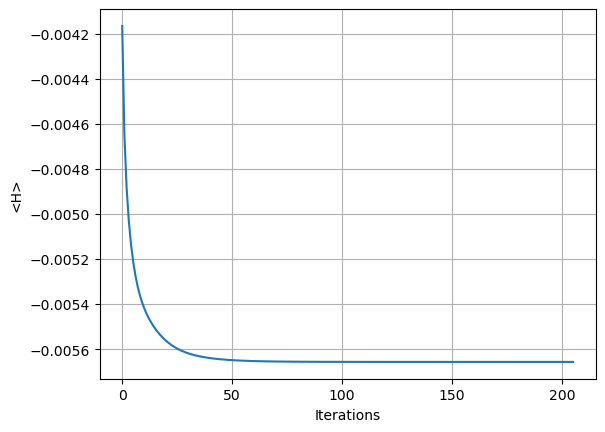

In [20]:
params = np.round(params, 10)  
costs.append(circuit(params))
plt.plot(costs)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("<H>")

Now, we do the same thing, but with different ansatz, where we will entangle qubits after the 1st rotation layer, and then apply the 2nd arbitratry RY rotations

In [14]:
dev_local_VQE2 = qml.device("default.qubit", wires=H.wires)
@qml.qnode(dev_local_VQE2)
def circuit2(params):
    params_1layer, params_2layer = params[:10], params[10:]
    
    for param, wire in zip(params_1layer, H.wires):
        qml.RY(param, wires = wire)
    for i in range(9):
        qml.CNOT(wires=[i, i+1])
        
    qml.CNOT(wires=[9, 0])

    for param, wire in zip(params_2layer, H.wires):
        qml.RY(param, wires = wire)
        
    return qml.expval(H)

circuit2([0.0]*10*2)

tensor(-0.00488364, requires_grad=True)

In [15]:
params2 = np.random.rand(len(H.wires), requires_grad=True)
opt2 = qml.AdagradOptimizer(stepsize = +0.25)
epochs = 200

costs2 = []
params_for_epoch2 = []

for epoch in range(epochs):
    params2, cost = opt2.step_and_cost(circuit, params2)
    costs2.append(cost)
    params_for_epoch2.append(params)

Text(0, 0.5, '<H>')

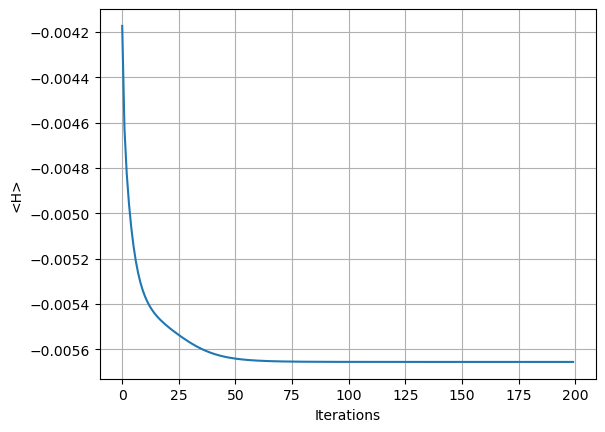

In [19]:
params = np.round(params, 10)  
costs.append(circuit(params2))
plt.plot(costs2)
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("<H>")

Let's compares this two loss dynamics:

Text(0, 0.5, '<H>')

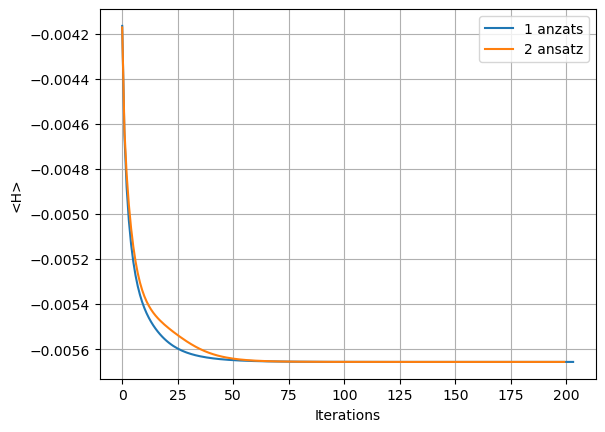

In [18]:
plt.plot(costs, label="1 anzats")
plt.plot(costs2, label="2 ansatz")
plt.legend()
plt.grid()
plt.xlabel("Iterations")
plt.ylabel("<H>")

From now on, to be honest, there are not noticebable changes in the loss dynamics, because, as we have added the more complexity to the anzats circuit, the more complex behaviour of loss function has become under the gradient descent.

Nevertheless, the main question is to investigate how would noise presence affect these two configurations (at least) of anzatses.

My prediction, which is based, for example, on this article https://arxiv.org/pdf/2106.01264.pdf, is that more complex circuit will suffer less from the noise contribution, than the basic one.

Unfortunately, code written below to check if it's true on a real quantum device (IonQ), or, at least, take a real insight what will happen, can't be verified due to the high queues and time management mistakes during the QHack. However, I still think, that better to have something done (even with no noticable results), than to have nothing.

P.S. first VQE task ID to be computed is 34a1bc5b-b6d3-4479-82ec-b068626ecff2. I was hoping that I would have enough time even on the last day to at least check on of the anzats examples, but it didn't happen. Code cells below are dedicated to that.

#  Real device test

In [9]:
device_arn = "arn:aws:braket:::device/qpu/ionq/ionQdevice"
real_device = qml.device('braket.aws.qubit', device_arn=device_arn, wires=10, shots=10)

In [11]:
@qml.qnode(real_device)
def circuit(params):    
    for param, wire in zip(params, H.wires):
        qml.RY(param, wires = wire)
        
    return qml.expval(H)

In [10]:
np.random.seed(42)

In [ ]:
params = np.random.rand(len(H.wires), requires_grad=True)
opt = qml.AdagradOptimizer(stepsize = +0.25)
epochs = 100

costs = []
params_for_epoch = []

for epoch in range(epochs):
    params, cost = opt.step_and_cost(circuit, params)
    costs.append(cost)
    params_for_epoch.append(params)

In [ ]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")